In [1]:
import os
import cv2
import collections
import time 
import tqdm
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import roc_auc_score

In [2]:
from utils.rle_utils import  get_img, rle_decode, make_mask, mask2rle, heightwidthchannel_to_channelheightwidth

In [3]:
path = '../input/understanding_cloud_organization'
img_paths = '../input/understanding-clouds-resized'
os.listdir(path)

['train.csv', 'sample_submission.csv', 'train_images', 'test_images']

In [4]:
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [5]:
test_img_filenames = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [6]:
sub.head(12)

Image_Label EncodedPixels
0     002f507.jpg_Fish           1 1
1   002f507.jpg_Flower           1 1
2   002f507.jpg_Gravel           1 1
3    002f507.jpg_Sugar           1 1
4     0035ae9.jpg_Fish           1 1
5   0035ae9.jpg_Flower           1 1
6   0035ae9.jpg_Gravel           1 1
7    0035ae9.jpg_Sugar           1 1
8     0038327.jpg_Fish           1 1
9   0038327.jpg_Flower           1 1
10  0038327.jpg_Gravel           1 1
11   0038327.jpg_Sugar           1 1

In [7]:
test_img_filenames[:3]

array(['002f507.jpg', '0035ae9.jpg', '0038327.jpg'], dtype=object)

In [8]:
from postprocess.simple_postprocess import simple_post_process

In [9]:
best_threshold = 0.7
min_mask_size = 1_000

In [84]:
i = 10

img_array = np.load('../weights/efficientnetb2/masks_test/' + test_img_filenames[i] + '.npz')['arr_0']
img_array = img_array
img_array.shape, img_array.max(), img_array.min()

((4, 640, 320), 237, 0)

In [85]:
sub_img = img_array[0]
print(sub_img.max())
if sub_img.shape != (350, 525):
        sub_img = cv2.resize(sub_img, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
print(sub_img.max())

215
214


In [86]:
predict, num_predict = simple_post_process(sub_img / 255,
                                           best_threshold,
                                           min_mask_size)

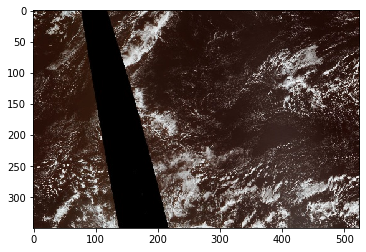

In [99]:
image = cv2.imread('../input/understanding-clouds-resized/test_images_525/test_images_525/' + test_img_filenames[i])
plt.imshow(image)

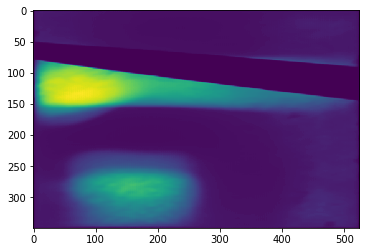

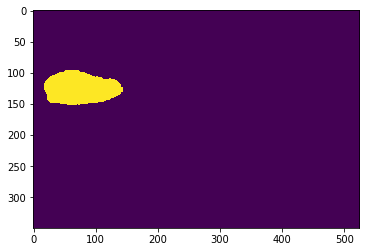

In [88]:
plt.imshow(sub_img / 255)
plt.show()
plt.imshow(predict)

In [130]:
def encode_masks(folder, image_filenames, threshold=0.5, min_mask_size=0):
    encoded_pixels = []
    image_id = 0
    for img_filename in tqdm.tqdm(image_filenames):
        img_array = np.load(folder + img_filename + '.npz')['arr_0']
        for i in range(4):
            sub_img = img_array[i]
            sub_img = sub_img.T
            if sub_img.shape != (350, 525):
                    sub_img = cv2.resize(sub_img, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)

            predict, num_predict = simple_post_process(sub_img / 255,
                                                       threshold,
                                                       min_mask_size)
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                r = mask2rle(predict)
                encoded_pixels.append(r)
    return encoded_pixels

In [131]:
encoded_sample = encode_masks('../weights/efficientnetb2/masks_test/',
                              test_img_filenames[:1],
                              threshold=0.5,
                              min_mask_size=0)

100%|██████████| 1/1 [00:00<00:00, 30.43it/s]


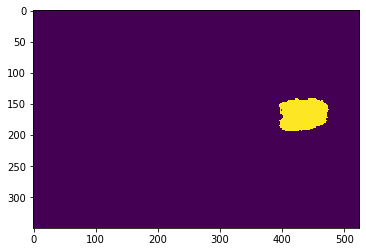

In [132]:
plt.imshow(rle_decode(encoded_sample[3],  shape=(350, 525)))

In [133]:
img_array = np.load('../weights/efficientnetb2/masks_test/' + test_img_filenames[0] + '.npz')['arr_0']

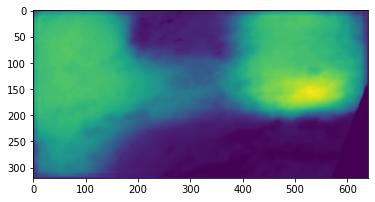

In [134]:
plt.imshow(img_array[3].T)

In [135]:
sub_img = img_array[3]
sub_img = sub_img.T
if sub_img.shape != (350, 525):
        sub_img = cv2.resize(sub_img, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)


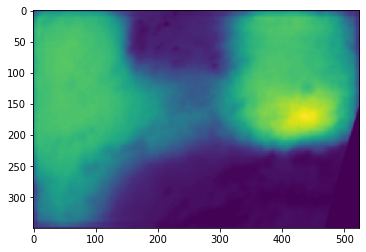

In [136]:
plt.imshow(sub_img)

In [137]:
train = pd.read_csv(f'{path}/train.csv')

In [138]:
train.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

In [139]:
def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

In [140]:
def get_iou(rle_encoded_true, rle_encoded_pred):
    iou = 0
    for rle_1, rle_2 in tqdm.tqdm(zip(rle_encoded_true, rle_encoded_pred)):
        mask_1 = rle_decode(str(rle_1))
        mask_1 = cv2.resize(mask_1, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
        mask_2 = rle_decode(str(rle_2),  shape=(350, 525))
        if (mask_1.sum() == 0) and (mask_2.sum() == 0):
            iou += 1
        else:
            iou += dice(mask_1, mask_2)
    return iou/len(rle_encoded_true)

In [141]:
#encoded_pixels_test = encode_masks('../weights/efficientnetb2/masks_test/', test_img_filenames)

In [142]:
train_img_filenames = train['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [143]:
hist = []
subsample = 100

for t in range(0, 100, 5):
    t /= 100
    for ms in [0, 100, 1200, 5000, 10000]:
        encoded_pixels_train = encode_masks('../weights/efficientnetb2/masks_oof/',
                                            train_img_filenames[:subsample],
                                            threshold=t,
                                            min_mask_size=ms)
        iou = get_iou(train['EncodedPixels'].to_list()[:subsample], encoded_pixels_train)
        hist.append([t, ms, iou])

100%|██████████| 100/100 [00:01<00:00, 80.79it/s]
100it [00:00, 255.86it/s]
100%|██████████| 100/100 [00:01<00:00, 82.48it/s]
100it [00:00, 232.99it/s]
100%|██████████| 100/100 [00:01<00:00, 89.45it/s]
100it [00:00, 248.19it/s]
100%|██████████| 100/100 [00:01<00:00, 89.13it/s]
100it [00:00, 255.22it/s]
100%|██████████| 100/100 [00:01<00:00, 90.22it/s]
100it [00:00, 252.09it/s]
100%|██████████| 100/100 [00:03<00:00, 30.99it/s]
100it [00:00, 220.03it/s]
100%|██████████| 100/100 [00:03<00:00, 32.43it/s]
100it [00:00, 219.26it/s]
100%|██████████| 100/100 [00:03<00:00, 33.26it/s]
100it [00:00, 227.63it/s]
100%|██████████| 100/100 [00:02<00:00, 34.44it/s]
100it [00:00, 234.25it/s]
100%|██████████| 100/100 [00:02<00:00, 35.04it/s]
100it [00:00, 220.29it/s]
100%|██████████| 100/100 [00:01<00:00, 57.92it/s]
100it [00:00, 224.79it/s]
100%|██████████| 100/100 [00:01<00:00, 60.39it/s]
100it [00:00, 221.43it/s]
100%|██████████| 100/100 [00:01<00:00, 61.92it/s]
100it [00:00, 236.60it/s]
100%|███████

In [144]:
best_stats = hist[np.argmax(np.array([stats[-1] for stats in hist]))]
best_stats

[0.35, 5000, 0.6245740133107763]

In [145]:
encoded_pixels_train = encode_masks('../weights/efficientnetb2/masks_oof/',
                                    train_img_filenames,
                                    threshold=best_stats[0],
                                    min_mask_size=best_stats[1])
iou = get_iou(train['EncodedPixels'].to_list(), encoded_pixels_train)
iou

100%|██████████| 5546/5546 [00:55<00:00, 100.36it/s]
22184it [01:28, 250.31it/s]


0.6233243573373056

In [146]:
encoded_pixels_test = encode_masks('../weights/efficientnetb2/masks_test/',
                                    test_img_filenames,
                                    threshold=best_stats[0],
                                    min_mask_size=best_stats[1])

100%|██████████| 3698/3698 [00:39<00:00, 94.47it/s] 


(array([1.1415e+04, 3.9110e+03, 2.9160e+03, 1.8970e+03, 1.1480e+03,
        5.7500e+02, 2.5500e+02, 5.6000e+01, 9.0000e+00, 2.0000e+00]),
 array([3.00000e+00, 6.91430e+03, 1.38256e+04, 2.07369e+04, 2.76482e+04,
        3.45595e+04, 4.14708e+04, 4.83821e+04, 5.52934e+04, 6.22047e+04,
        6.91160e+04]),
 <a list of 10 Patch objects>)

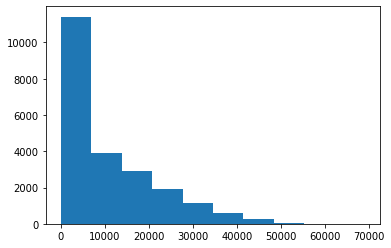

In [147]:
plt.hist([len(str(rle)) for rle in train['EncodedPixels'].to_list()])

(array([1.058e+04, 3.664e+03, 3.455e+03, 2.984e+03, 1.278e+03, 1.690e+02,
        4.100e+01, 9.000e+00, 3.000e+00, 1.000e+00]),
 array([    0. ,  1314.7,  2629.4,  3944.1,  5258.8,  6573.5,  7888.2,
         9202.9, 10517.6, 11832.3, 13147. ]),
 <a list of 10 Patch objects>)

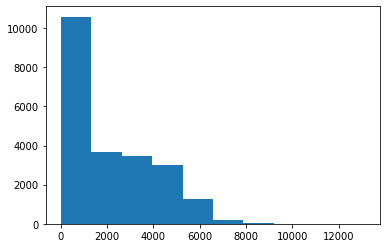

In [148]:
plt.hist([len(rle) for rle in encoded_pixels_train])

(array([6.687e+03, 2.685e+03, 2.379e+03, 2.246e+03, 6.530e+02, 1.060e+02,
        2.600e+01, 7.000e+00, 2.000e+00, 1.000e+00]),
 array([    0. ,  1376.2,  2752.4,  4128.6,  5504.8,  6881. ,  8257.2,
         9633.4, 11009.6, 12385.8, 13762. ]),
 <a list of 10 Patch objects>)

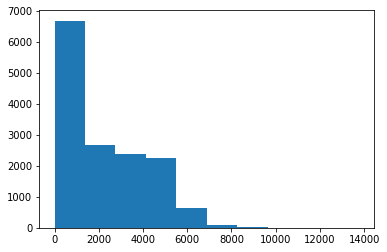

In [149]:
plt.hist([len(rle) for rle in encoded_pixels_test])

In [151]:
sub['EncodedPixels'] = encoded_pixels_test
sub.to_csv('../weights/efficientnetb2/submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)

In [ ]:
# Leaderboard: 0.603